<a href="https://colab.research.google.com/github/erichsiao1106/Aiottest/blob/master/0831age_gender_keras_vggface_mlp256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 4.7MB/s 


In [ ]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

#import tensorflow as tf
#from tensorflow import keras
import keras
from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import metrics

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import load_model
import cv2
from glob import glob
import os
from mtcnn import MTCNN

In [ ]:
df = pd.read_csv('drive/My Drive/AIoT_Project/Datasets/資料集_IMDB-Wiki/wiki_crop/wiki_mat.csv')

FileNotFoundError: ignored

In [ ]:
#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df = df[df['age'] <= 100]
 
#some guys seem to be unborn in the data set
df = df[df['age'] > 0]
df['age'] = df['age']//10
df

,full_path,gender,age
0,17/10000217_1981-05-05_2009.jpg,1.0,2
1,12/100012_1948-07-03_2008.jpg,1.0,6
2,16/10002116_1971-05-31_2012.jpg,0.0,4
3,02/10002702_1960-11-09_2012.jpg,0.0,5
4,41/10003541_1937-09-27_1971.jpg,1.0,3
...,...,...,...
22150,38/9996938_1937-02-15_1968.jpg,1.0,3
22151,46/9996946_1943-11-01_1968.jpg,1.0,2
22152,49/9996949_1937-04-17_1963.jpg,1.0,2
22153,09/9998109_1972-12-27_2013.jpg,1.0,4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

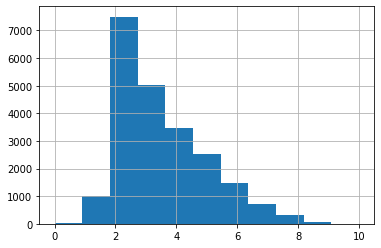

In [ ]:
histogram_age = df['age'].hist(bins=df['age'].nunique())

In [ ]:
# 處理答案 把它轉成one-hot
y_train_category = to_categorical(df['age'])

# 切分訓練data
x_train, x_test, y_train, y_test = train_test_split(np.array(df['full_path']), np.array(y_train_category), test_size=0.2)
print(x_train[0], x_test[0], y_train[0], y_train[0].argmax(axis=-1), y_test[0].argmax(axis=-1))
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

89/5377589_1956-05-19_2012.jpg 72/22919372_1954-08-16_2009.jpg [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 5 5
(17710,) (4428,) (17710, 11) (4428, 11)


In [ ]:
folder_path = 'drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki'
detector = MTCNN()
#feature_extractor = load_model(os.path.join(folder_path, 'facenet.h5'))
#feature_extractor = load_model(os.path.join(folder_path, 'facenet_keras.h5'))

In [ ]:
# VGGFace: https://github.com/rcmalli/keras-vggface
!pip install keras_vggface
!pip install keras_applications

from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
feature_extractor = VGGFace(model='resnet50', include_top=False, 
            input_shape=(224, 224, 3), pooling='avg')

     |████████████████████████████████| 51kB 1.6MB/s 
94699520/94694792 [==============================] - 7s 0us/step


In [ ]:
feature_extractor.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_4[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [ ]:
# 固定pre-train model的參數
for lyr in feature_extractor.layers:
    lyr.trainable = False

# BN
x = BatchNormalization()(feature_extractor.output)    
    
# MLP    
# x = Flatten()(x)

#x = Dense(units=2048, activation='relu')(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=11, activation='softmax')(x)
age_model = Model(inputs=feature_extractor.input, outputs=x)   
age_model.summary() 

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_4[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
_______________________________________________________________________________________

In [ ]:
age_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

model_folder_path = 'drive/My Drive/Tibame_AIoT_Project/face'
age_model.load_weights(os.path.join(model_folder_path,'keras_vggface_weights_age_256.h5'))

In [ ]:
# 資料預處理 for facenet?
# Standardization
def preprocess(imgs): 
    for i in range(imgs.shape[0]):
        # standardization
        img = imgs[i]
        mean, std = img.mean(), img.std()
        img = (img - mean) / std
        imgs[i] = img
    return imgs
# Normalization
def normalize(img):
    return img / 255.

# -1 <= x <= 1
def preprocess_1(imgs):
    x = np.array(imgs, dtype = float)
    x /= 127.5
    x -= 1.
    return x    

In [ ]:
# n = np.array([[255,127,1],
#         [128,200,255]])
# print(preprocess_1(n))
# print(n)
# print(preprocess(n))
# print(n)

In [ ]:
# detect face
def detect_faces(img):
    face_imgs = []
    results = detector.detect_faces(img)
    # extract the bounding box from the first face
    # print('# of faces: ', len(results))
    for i in range(len(results)):
        x1, y1, width, height = results[i]['box']
        x2, y2 = x1 + width, y1 + height
        patch = img[y1:y2, x1:x2] # crop face
        face_imgs.append(patch)
    return face_imgs

In [ ]:
img_folder_path = 'drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/wiki_crop'
def get_data(x, y, batch=20, IMG_SIZE=160):
    # 要注意 numpy 中的 randint 的上限是不包含的 和一般的randint不同
    # numpy array 的索引可以是個 list, 即可同時取出不只一個元素
    idx = np.random.randint(0, len(x), batch)
    x_idx, y_idx = x[idx], y[idx]
    x_ori, x_norm, y_ori = [], [], y_idx
    for i,p in enumerate(x_idx):
        #print(p[0])
        #print(y_idx[i].argmax(axis=-1))
        # 讀取圖片並使用借來的模型的預處理方式來作預處理
        # img = np.array(load_img(os.path.join(img_folder_path,p[0]), target_size=(224, 224)))
        # 讀取圖片並切下臉的部分
        img = np.array(cv2.imread(os.path.join(img_folder_path,p))[:,:,::-1])
        # plt.imshow(img)
        # plt.show()
        faces = detect_faces(img)
        if len(faces) == 0:
            print('No face')
            continue   
        img = cv2.resize(faces[0], (IMG_SIZE, IMG_SIZE))
        # plt.imshow(faces[0])
        # plt.show()

        # 使用借來的模型的預處理方式來作預處理
        img_pre = preprocess_input(np.array(img,dtype=float))
        #img_pre = preprocess_1(img)
        #img_pre = normalize(img)
        
        # 把原圖留下來
        x_ori.append(img)
        x_norm.append(img_pre)
    return np.array(x_ori), np.array(x_norm), np.array(y_ori)

In [ ]:
# 批次訓練
i = 0
while i < 100:
    print("[times]:", i)
    x_ori_batch, x_batch, y_batch = get_data(x_train, y_train, IMG_SIZE=224)
    print("preprocess:", x_ori_batch[0,0,0,:], "==>", x_batch[0,0,0,:] )
    print(x_batch.shape, y_batch.shape)
    if x_batch.shape[0] != y_batch.shape[0]:
        continue
    result = age_model.train_on_batch(x_batch, y_batch, reset_metrics=False)
    print("[Train]:", result)
    
    # _, x_batch, y_batch = get_data(x_test, y_test, IMG_SIZE=224)
    # print(x_batch.shape, y_batch.shape)
    # if x_batch.shape[0] != y_batch.shape[0]:
    #     continue    
    # result = age_model.test_on_batch(x_batch, y_batch)
    # print("[Test]:", result)

    i += 1

[times]: 0
preprocess: [93 70 64] ==> [-29.594  -34.7624 -36.1863]
(20, 224, 224, 3) (20, 11)
[Train]: [2.0194480419158936, 0.4000000059604645]
[times]: 1
preprocess: [233 190 174] ==> [ 80.406   85.2376 103.8137]
(20, 224, 224, 3) (20, 11)
[Train]: [1.8894611597061157, 0.42500001192092896]
[times]: 2
preprocess: [125 114 108] ==> [14.406   9.2376 -4.1863]
(20, 224, 224, 3) (20, 11)
[Train]: [2.054832696914673, 0.38333332538604736]
[times]: 3
preprocess: [154 150 121] ==> [27.406  45.2376 24.8137]
(20, 224, 224, 3) (20, 11)
[Train]: [2.115879535675049, 0.36250001192092896]
[times]: 4
preprocess: [47 42 38] ==> [-55.594  -62.7624 -82.1863]
(20, 224, 224, 3) (20, 11)
[Train]: [2.1471681594848633, 0.36000001430511475]
[times]: 5
preprocess: [151 131 122] ==> [28.406  26.2376 21.8137]
(20, 224, 224, 3) (20, 11)
[Train]: [2.139561891555786, 0.38333332538604736]
[times]: 6
preprocess: [247 246 241] ==> [147.406  141.2376 117.8137]
(20, 224, 224, 3) (20, 11)
[Train]: [2.094536542892456, 0.400

In [ ]:
model_folder_path = 'drive/My Drive/Tibame_AIoT_Project/face'
age_model.save_weights(os.path.join(model_folder_path,'keras_vggface_weights_age_256.h5'))

In [ ]:
# evaluate
_, x_batch, y_batch = get_data(x_test, y_test, IMG_SIZE=224)
age_model.evaluate(x_batch, y_batch)

1/1 [==============================] - 0s 2ms/step - loss: 1.5501 - accuracy: 0.3000


[1.5501019954681396, 0.30000001192092896]

In [ ]:
def euclidean_distance(x, y):
    sum_square = np.sum(np.square(x - y), keepdims=True)
    return np.sqrt(sum_square)

In [ ]:
def predict_age(img):
    img_size = 100
    img = normalize(img)
    img = cv2.resize(img, (img_size, img_size))
    model_input = np.zeros((1, img_size, img_size, 3))
    model_input[0] = img
    ages = age_model.predict(model_input)
    print('age: ', ages.argmax(axis=-1))
    return 

# def predict_gender(img):
#     img_size = 100
#     img = normalize(img)
#     img = cv2.resize(img, (img_size, img_size))
#     model_input = np.zeros((1, img_size, img_size, 3))
#     model_input[0] = img
#     genders = model_gender.predict(model_input)
#     gender = genders[0]
#     if gender > 0.5:
#         print('Male')
#     else:
#         print('Female')
#     return    

In [ ]:
def face_id(filename, IMG_SIZE=160):
    raw_img = cv2.imread(os.path.join(folder_path, filename))[:,:,::-1]
    faces = detect_faces(raw_img)
    if len(faces) == 0:
        print('No face')
        return
    else:
        # get face embeddings
        face = faces[0]
        # More predictions
        predict_age(face)
        # predict_emotion(face)
        # predict_gender(face)
        # # ID
        # face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
        # model_input = np.zeros((1, IMG_SIZE, IMG_SIZE, 3))
        # model_input[0] = face
        # model_input = preprocess(model_input)
        # query_embeddings = feature_extractor.predict(model_input)
        # query_embedding = query_embeddings[0]
        
        # # compute distance
        # distances = np.zeros((len(embeddings)))
        # for i, embed in enumerate(embeddings):
        #     distance = euclidean_distance(embed, query_embedding)
        #     distances[i] = distance

        # # find min distance    
        # idx_min = np.argmin(distances)
        # distance, name = distances[idx_min], names[idx_min]
        # print('name: ', name, ' distance: ',distance)

In [ ]:
folder_path = '/content/drive/My Drive/week10/face_detection'
path = 'face3.jpg'
face_id(path)
plt.imshow(cv2.imread(os.path.join(folder_path, path))[:,:,::-1])